In [38]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
import torch
from time import time
from tqdm import tqdm

In [40]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [41]:
from utils.tools import *

# Constants

In [42]:
INPUT_DIM = 50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(5e3)
N_VAL = 100
VAL_ITER = 100
N_MAX_NEURONS = 2000
LAMBDA = 0.1

In [43]:
FIGURES_DIR = os.path.join(ROOT, 'figures/ista')
create_dir(FIGURES_DIR)

In [44]:
set_random_seeds(SEED)

# Data

In [45]:
def forward(a, b, x):
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T) / a.shape[1]

In [46]:
# Teacher Network
m = 50 # number of teacher neurons
eps = 3e-1

a_star = 2 * np.sign(np.random.uniform(size=(1, m)) - 0.5) # / m
b_star = 2 * np.random.uniform(size=(m, INPUT_DIM)) - 1 - eps * np.random.normal(size=(m, INPUT_DIM))**2

In [47]:
# Data
x_train = np.random.normal(size=(N_TRAIN, INPUT_DIM))
y_train = forward(a_star, b_star, x_train)

x_val = np.random.normal(size=(N_VAL, INPUT_DIM))
y_val = forward(a_star, b_star, x_val)

# Algorithm iterations

In [48]:
def relu_prime(z):
    return (np.sign(z) + 1) / 2

In [49]:
def sample_neurons(n_samples=1):
    return np.random.normal(size=(n_samples, INPUT_DIM))

In [50]:
def forward_states(a, b, x):
    h_1 = np.matmul(x, b.T)
    x_1 = np.maximum(h_1, 0)
    y_hat = np.matmul(x_1, a.T) / a.shape[1]
    
    return h_1, x_1, y_hat

In [51]:
def initialize_neurons(x, y, n_neurons=1):
    # empty arrays and null prediction function
    a = np.array([[]])
    b = np.array([[]])
    y_hat = 0

    b_hat = sample_neurons(n_samples=n_neurons)
    x_1 = np.maximum(np.matmul(x, b_hat.T), 0)
    a_hat = - ALPHA * np.mean((y_hat - y) * x_1, axis=0)

    a = np.append(a, a_hat).reshape(1, n_neurons)
    b = np.append(b, b_hat).reshape(n_neurons, -1)

    return a, b

Soft thresholding
$$\text{soft_thresholding}(a, \tau)_j = a_j \max\left(0,1 - \frac{\tau}{|a_j|} \right) $$

In [52]:
def soft_thresholding(a, param, eps=1.0e-6):
    where_non_zero = (np.abs(a[0, :]) >= eps)
    a[0, where_non_zero] = a[0, where_non_zero] * np.maximum(1 - param / np.abs(a[0, where_non_zero]), 0)
    a[0, ~where_non_zero] = 0.
    return a

In [53]:
def update(a, b, x, y, n_updates=1, compute_loss=True, st=False):
    # st = 'soft thresholding'
    for _ in range(n_updates):
        h_1, x_1, y_hat = forward_states(a, b, x)
        delta = y_hat - y
        b = b - BASE_LR * np.matmul(np.matmul(relu_prime(h_1), np.diag(a.reshape(-1))).T,
                                    delta * x) / N_TRAIN
        a = a - BASE_LR * np.mean(delta * x_1, axis=0, keepdims=True)
        if st:
            a = soft_thresholding(a, param=BASE_LR * LAMBDA)
            where_non_zero = (np.abs(a[0, :]) > 0.)
            a = a[:, where_non_zero]
            b = b[where_non_zero, :]

    loss = -1.0
    if compute_loss:
        loss = 0.5 * np.mean(delta ** 2)

    return a, b, loss

In [54]:
def initialize_net(x, y, n_neurons=1, st=False):
    # initialize neurons  y sampling and setting weights accordingly
    a, b = initialize_neurons(x, y, n_neurons=n_neurons)

    # return as initialization for the network the first update for the sampled neurons / weights
    return update(a, b, x, y, n_updates=1, st=st)

In [55]:
def train(n_steps, a, b, x_train, y_train, x_val, y_val, do_val=True, n_samples=1, n_updates=1, st=True):
    train_losses = []
    val_losses = []
    neurons = [a.shape[1]]

    for i in tqdm(range(n_steps)):
        # sample neurons and set weights
        if n_samples > 0:
            if a.shape[1] <= N_MAX_NEURONS:
                b_hat = sample_neurons(n_samples=n_samples)
                x_1 = np.maximum(np.matmul(x_train, b_hat.T), 0)
                y_hat = forward(a, b, x_train)
                a_hat = - ALPHA * np.mean((y_hat - y_train) * x_1, axis=0, keepdims=True)

                # add newly sampled neurons / weights to the list
                a = np.hstack((a, a_hat))
                b = np.vstack((b, b_hat))
                
            neurons.append(a.shape[1])

        # update neurons / weights
        a, b, train_loss = update(a, b, x_train, y_train, n_updates=n_updates, st=st)
        train_losses.append(train_loss)

        # validation loop if do_val is True
        if do_val:
            if i % VAL_ITER == 0:
                y_hat = forward(a, b, x_val)
                val_loss = 0.5 * np.mean((y_hat - y_val) ** 2)
                val_losses.append(val_loss)
                print('Train loss at step {:,} : {:.5f}'.format(i, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(i, val_loss))
    
    # last validation round at the end of training
    if do_val:
        y_hat = forward(a, b, x_val)
        val_loss = 0.5 * np.mean((y_hat - y_val) ** 2)
        val_losses.append(val_loss)
        print('Train loss at step {:,} : {:.5f}'.format(i, train_loss))
        print('Validation loss at step {:,} : {:.5f}'.format(i, val_loss))

    return a, b, np.array(train_losses), np.array(val_losses), np.array(neurons)

## 1. Pop-conic ISTA 

Update rule is modified via
\begin{align*}
    \tilde a_j(k+1) &= a_j(k) - \eta \frac{1}{n} \sum_{i=1}^n (\hat y_i - y_i) \sigma(b_j^\top x_i)\\
    a_{k+1} &= \tilde a_{k+1} \max\left(0,1 - \frac{\lambda \eta}{|\tilde a_{k+1}|} \right) \\
    \text{ins}& \text{tead of} \\
    a_j(k+1) &= a_j(k) - \eta \frac{1}{n} \sum_{i=1}^n (\hat y_i - y_i) \sigma(b_j^\top x_i)
\end{align*}

In [56]:
# FULL LOOP (POP-CONIC 1 sample & 1 update per step)
n_neurons = 1
n_updates = 1
st = True

a, b, _ = initialize_net(x_train, y_train, n_neurons=n_neurons, st=False)
a, b, train_losses, val_losses, neurons = train(N_STEPS, a, b, x_train, y_train, x_val, y_val, n_samples=n_neurons, 
                                                n_updates=n_updates, st=st)

  1%|▎                                       | 39/5000 [00:00<00:12, 387.34it/s]

Train loss at step 0 : 0.34576
Validation loss at step 0 : 0.29291


  3%|█▏                                     | 147/5000 [00:00<00:18, 264.22it/s]

Train loss at step 100 : 0.27171
Validation loss at step 100 : 0.23138


  4%|█▋                                     | 221/5000 [00:00<00:23, 199.79it/s]

Train loss at step 200 : 0.22522
Validation loss at step 200 : 0.20532


  6%|██▍                                    | 320/5000 [00:01<00:38, 122.55it/s]

Train loss at step 300 : 0.17318
Validation loss at step 300 : 0.17544


  8%|███▎                                    | 407/5000 [00:03<00:59, 77.81it/s]

Train loss at step 400 : 0.13179
Validation loss at step 400 : 0.15026


 10%|████                                    | 505/5000 [00:04<00:56, 79.12it/s]

Train loss at step 500 : 0.09914
Validation loss at step 500 : 0.13254


 12%|████▉                                   | 617/5000 [00:05<00:51, 84.84it/s]

Train loss at step 600 : 0.07874
Validation loss at step 600 : 0.12255


 14%|█████▌                                 | 720/5000 [00:06<00:42, 100.27it/s]

Train loss at step 700 : 0.06207
Validation loss at step 700 : 0.11635


 16%|██████▍                                | 818/5000 [00:07<00:39, 106.28it/s]

Train loss at step 800 : 0.04935
Validation loss at step 800 : 0.11322


 18%|███████▏                               | 922/5000 [00:08<00:36, 113.01it/s]

Train loss at step 900 : 0.03985
Validation loss at step 900 : 0.11493


 20%|███████▋                              | 1018/5000 [00:09<00:29, 134.80it/s]

Train loss at step 1,000 : 0.03426
Validation loss at step 1,000 : 0.11769


 22%|████████▌                             | 1124/5000 [00:10<00:27, 142.36it/s]

Train loss at step 1,100 : 0.03018
Validation loss at step 1,100 : 0.11873


 24%|█████████▎                            | 1224/5000 [00:11<00:22, 166.59it/s]

Train loss at step 1,200 : 0.02720
Validation loss at step 1,200 : 0.12027


 27%|██████████                            | 1330/5000 [00:11<00:18, 200.98it/s]

Train loss at step 1,300 : 0.02439
Validation loss at step 1,300 : 0.11689


 29%|██████████▉                           | 1439/5000 [00:12<00:16, 210.81it/s]

Train loss at step 1,400 : 0.02249
Validation loss at step 1,400 : 0.11696


 31%|███████████▋                          | 1530/5000 [00:12<00:15, 220.54it/s]

Train loss at step 1,500 : 0.02107
Validation loss at step 1,500 : 0.11688


 33%|████████████▍                         | 1640/5000 [00:13<00:13, 257.27it/s]

Train loss at step 1,600 : 0.01960
Validation loss at step 1,600 : 0.11927


 35%|█████████████▎                        | 1759/5000 [00:13<00:11, 287.30it/s]

Train loss at step 1,700 : 0.01840
Validation loss at step 1,700 : 0.12177


 37%|██████████████                        | 1851/5000 [00:13<00:11, 263.96it/s]

Train loss at step 1,800 : 0.01785
Validation loss at step 1,800 : 0.11872


 39%|██████████████▊                       | 1941/5000 [00:14<00:11, 266.40it/s]

Train loss at step 1,900 : 0.01754
Validation loss at step 1,900 : 0.11848


 41%|███████████████▋                      | 2064/5000 [00:14<00:10, 285.43it/s]

Train loss at step 2,000 : 0.01662
Validation loss at step 2,000 : 0.11984


 43%|████████████████▎                     | 2152/5000 [00:15<00:10, 273.15it/s]

Train loss at step 2,100 : 0.01611
Validation loss at step 2,100 : 0.12233


 45%|█████████████████                     | 2247/5000 [00:15<00:09, 298.56it/s]

Train loss at step 2,200 : 0.01644
Validation loss at step 2,200 : 0.11852


 47%|█████████████████▊                    | 2345/5000 [00:15<00:10, 261.56it/s]

Train loss at step 2,300 : 0.01657
Validation loss at step 2,300 : 0.11732


 49%|██████████████████▌                   | 2449/5000 [00:16<00:08, 311.42it/s]

Train loss at step 2,400 : 0.01535
Validation loss at step 2,400 : 0.12144


 51%|███████████████████▍                  | 2562/5000 [00:16<00:06, 353.67it/s]

Train loss at step 2,500 : 0.01489
Validation loss at step 2,500 : 0.12144


 54%|████████████████████▍                 | 2685/5000 [00:16<00:05, 393.42it/s]

Train loss at step 2,600 : 0.01647
Validation loss at step 2,600 : 0.11784


 55%|████████████████████▉                 | 2762/5000 [00:17<00:06, 356.87it/s]

Train loss at step 2,700 : 0.01594
Validation loss at step 2,700 : 0.11731


 58%|█████████████████████▉                | 2890/5000 [00:17<00:05, 401.88it/s]

Train loss at step 2,800 : 0.01600
Validation loss at step 2,800 : 0.11771


 60%|██████████████████████▌               | 2976/5000 [00:17<00:04, 406.17it/s]

Train loss at step 2,900 : 0.01694
Validation loss at step 2,900 : 0.11534


 61%|███████████████████████▏              | 3055/5000 [00:17<00:05, 352.75it/s]

Train loss at step 3,000 : 0.03069
Validation loss at step 3,000 : 0.10913


 63%|████████████████████████              | 3160/5000 [00:18<00:05, 317.70it/s]

Train loss at step 3,100 : 0.02209
Validation loss at step 3,100 : 0.10629


 65%|████████████████████████▊             | 3269/5000 [00:18<00:04, 346.71it/s]

Train loss at step 3,200 : 0.01362
Validation loss at step 3,200 : 0.12878


 67%|█████████████████████████▍            | 3351/5000 [00:18<00:04, 377.56it/s]

Train loss at step 3,300 : 0.01333
Validation loss at step 3,300 : 0.12758


 69%|██████████████████████████▎           | 3470/5000 [00:18<00:04, 382.03it/s]

Train loss at step 3,400 : 0.01363
Validation loss at step 3,400 : 0.12189


 71%|███████████████████████████           | 3554/5000 [00:19<00:03, 391.70it/s]

Train loss at step 3,500 : 0.01449
Validation loss at step 3,500 : 0.12213


 74%|████████████████████████████          | 3694/5000 [00:19<00:02, 442.11it/s]

Train loss at step 3,600 : 0.01476
Validation loss at step 3,600 : 0.11968


 76%|████████████████████████████▋         | 3782/5000 [00:19<00:03, 404.59it/s]

Train loss at step 3,700 : 0.02355
Validation loss at step 3,700 : 0.11108


 76%|█████████████████████████████         | 3823/5000 [00:19<00:03, 361.47it/s]

Train loss at step 3,800 : 0.04472
Validation loss at step 3,800 : 0.11080


 79%|█████████████████████████████▊        | 3926/5000 [00:20<00:03, 276.09it/s]

Train loss at step 3,900 : 0.04226
Validation loss at step 3,900 : 0.10903


 81%|██████████████████████████████▊       | 4053/5000 [00:21<00:04, 191.70it/s]

Train loss at step 4,000 : 0.01590
Validation loss at step 4,000 : 0.11198


 83%|███████████████████████████████▌      | 4157/5000 [00:21<00:02, 283.44it/s]

Train loss at step 4,100 : 0.01357
Validation loss at step 4,100 : 0.12557


 85%|████████████████████████████████▍     | 4271/5000 [00:21<00:02, 348.36it/s]

Train loss at step 4,200 : 0.01271
Validation loss at step 4,200 : 0.12870


 87%|█████████████████████████████████     | 4356/5000 [00:22<00:01, 382.90it/s]

Train loss at step 4,300 : 0.01220
Validation loss at step 4,300 : 0.13032


 90%|██████████████████████████████████    | 4485/5000 [00:22<00:01, 398.08it/s]

Train loss at step 4,400 : 0.01201
Validation loss at step 4,400 : 0.12919


 92%|██████████████████████████████████▊   | 4580/5000 [00:22<00:00, 422.14it/s]

Train loss at step 4,500 : 0.01221
Validation loss at step 4,500 : 0.12235
Train loss at step 4,600 : 0.01183
Validation loss at step 4,600 : 0.12575


 96%|████████████████████████████████████▌ | 4806/5000 [00:22<00:00, 642.70it/s]

Train loss at step 4,700 : 0.01192
Validation loss at step 4,700 : 0.12294
Train loss at step 4,800 : 0.01500
Validation loss at step 4,800 : 0.11359


100%|██████████████████████████████████████| 5000/5000 [00:23<00:00, 216.68it/s]

Train loss at step 4,900 : 0.01175
Validation loss at step 4,900 : 0.12707
Train loss at step 4,999 : 0.01142
Validation loss at step 4,999 : 0.12206


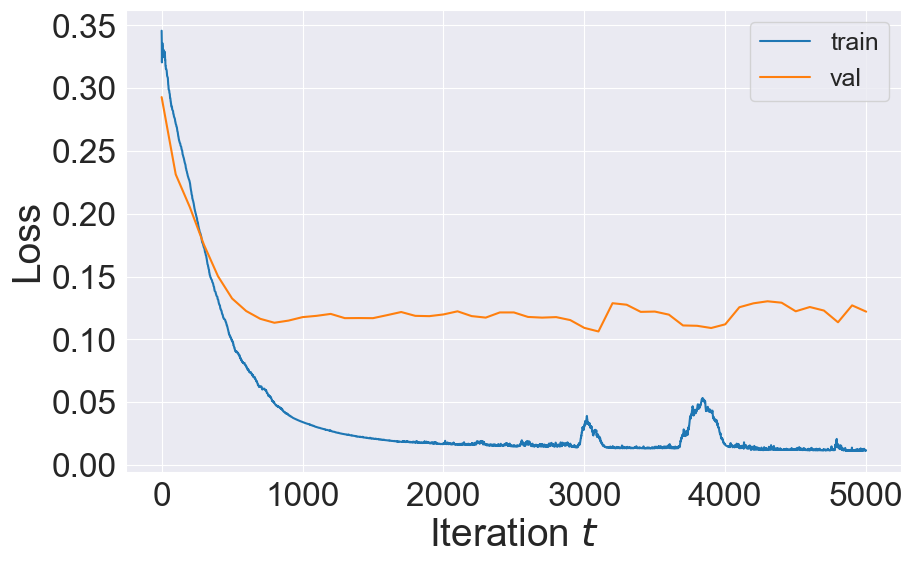

In [57]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val',
         marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-1-1.png'), bbox_inches='tight')
plt.show()

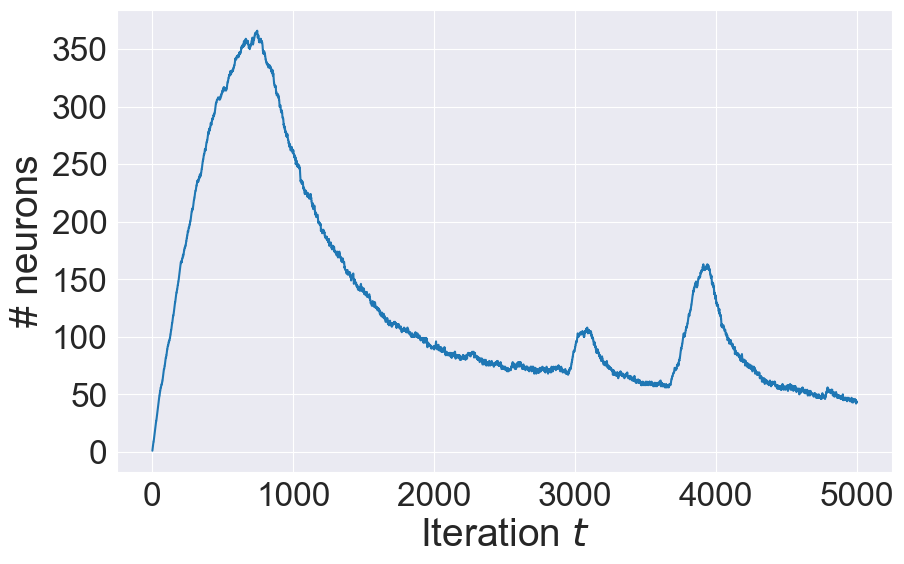

In [58]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(neurons)), neurons)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('# neurons', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'neurons-ista-1-1.png'), bbox_inches='tight')
plt.show()

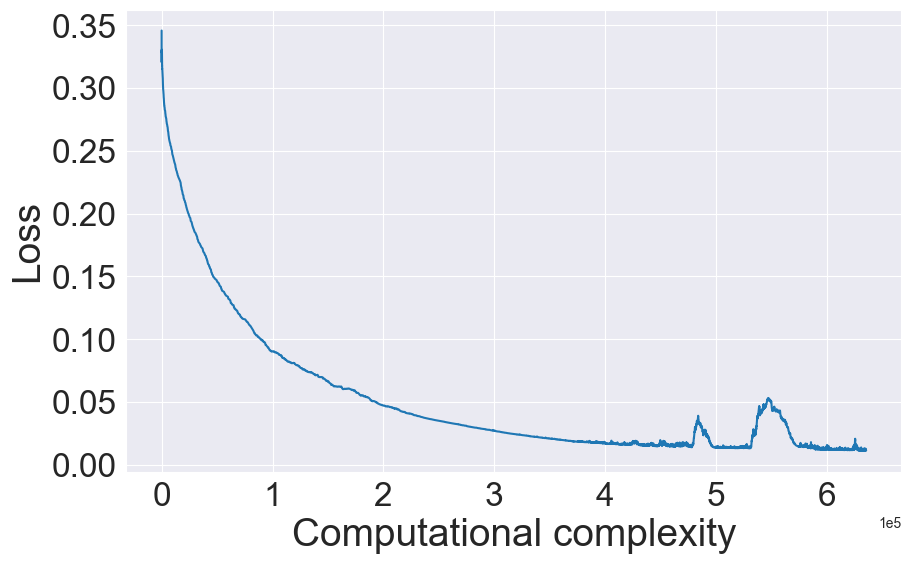

In [59]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.cumsum(neurons)[1:], train_losses)

plt.xlabel('Computational complexity', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-1-1.png'), bbox_inches='tight')
plt.show()

In [65]:
# FULL LOOP (POP-CONIC 10 samples & 1 update per step)
n_neurons = 10
n_updates = 1

a, b, _ = initialize_net(x_train, y_train, n_neurons=n_neurons)
a, b, train_losses, val_losses, neurons = train(N_STEPS, a, b, x_train, y_train, x_val, y_val, 
                                                n_samples=n_neurons, n_updates=n_updates)

  0%|                                          | 4/5000 [00:00<02:11, 38.06it/s]

Train loss at step 0 : 0.35141
Validation loss at step 0 : 0.29039


  2%|▊                                       | 102/5000 [00:02<03:52, 21.06it/s]

Train loss at step 100 : 0.26594
Validation loss at step 100 : 0.22782


  4%|█▌                                      | 202/5000 [00:12<11:12,  7.13it/s]

Train loss at step 200 : 0.21114
Validation loss at step 200 : 0.19312


  6%|██▍                                     | 302/5000 [00:29<12:29,  6.27it/s]

Train loss at step 300 : 0.15318
Validation loss at step 300 : 0.15700


  8%|███▏                                    | 402/5000 [00:44<11:23,  6.73it/s]

Train loss at step 400 : 0.10114
Validation loss at step 400 : 0.12819


 10%|████                                    | 502/5000 [00:59<12:03,  6.22it/s]

Train loss at step 500 : 0.07390
Validation loss at step 500 : 0.11532


 12%|████▊                                   | 602/5000 [01:15<11:38,  6.29it/s]

Train loss at step 600 : 0.05913
Validation loss at step 600 : 0.10961


 14%|█████▌                                  | 702/5000 [01:30<11:06,  6.44it/s]

Train loss at step 700 : 0.05026
Validation loss at step 700 : 0.10685


 16%|██████▍                                 | 802/5000 [01:44<09:50,  7.11it/s]

Train loss at step 800 : 0.04054
Validation loss at step 800 : 0.10627


 18%|███████▏                                | 903/5000 [01:56<06:08, 11.11it/s]

Train loss at step 900 : 0.03387
Validation loss at step 900 : 0.10807


 20%|███████▊                               | 1003/5000 [02:06<05:49, 11.45it/s]

Train loss at step 1,000 : 0.02926
Validation loss at step 1,000 : 0.10895


 22%|████████▌                              | 1103/5000 [02:13<05:08, 12.63it/s]

Train loss at step 1,100 : 0.02564
Validation loss at step 1,100 : 0.10844


 24%|█████████▍                             | 1204/5000 [02:19<03:21, 18.82it/s]

Train loss at step 1,200 : 0.02271
Validation loss at step 1,200 : 0.10748


 26%|██████████▏                            | 1303/5000 [02:24<02:57, 20.82it/s]

Train loss at step 1,300 : 0.02002
Validation loss at step 1,300 : 0.10774


 28%|██████████▉                            | 1405/5000 [02:28<02:15, 26.46it/s]

Train loss at step 1,400 : 0.01779
Validation loss at step 1,400 : 0.10847


 30%|███████████▋                           | 1506/5000 [02:32<01:46, 32.93it/s]

Train loss at step 1,500 : 0.01569
Validation loss at step 1,500 : 0.10863


 32%|████████████▌                          | 1606/5000 [02:35<01:26, 39.32it/s]

Train loss at step 1,600 : 0.01405
Validation loss at step 1,600 : 0.10778


 34%|█████████████▎                         | 1706/5000 [02:37<01:27, 37.82it/s]

Train loss at step 1,700 : 0.01249
Validation loss at step 1,700 : 0.10864


 36%|██████████████                         | 1809/5000 [02:39<01:01, 52.13it/s]

Train loss at step 1,800 : 0.01125
Validation loss at step 1,800 : 0.10865


 38%|██████████████▉                        | 1911/5000 [02:41<00:47, 65.22it/s]

Train loss at step 1,900 : 0.01033
Validation loss at step 1,900 : 0.10787


 40%|███████████████▋                       | 2013/5000 [02:43<00:41, 72.41it/s]

Train loss at step 2,000 : 0.00955
Validation loss at step 2,000 : 0.10798


 42%|████████████████▍                      | 2115/5000 [02:44<00:34, 84.01it/s]

Train loss at step 2,100 : 0.00893
Validation loss at step 2,100 : 0.10730


 44%|████████████████▉                     | 2222/5000 [02:45<00:27, 100.83it/s]

Train loss at step 2,200 : 0.00856
Validation loss at step 2,200 : 0.10601


 46%|█████████████████▋                    | 2325/5000 [02:46<00:23, 111.61it/s]

Train loss at step 2,300 : 0.00838
Validation loss at step 2,300 : 0.10588


 48%|██████████████████▎                   | 2415/5000 [02:47<00:20, 124.42it/s]

Train loss at step 2,400 : 0.00837
Validation loss at step 2,400 : 0.10441


 50%|███████████████████▏                  | 2521/5000 [02:48<00:22, 108.31it/s]

Train loss at step 2,500 : 0.00805
Validation loss at step 2,500 : 0.10445


 52%|███████████████████▉                  | 2618/5000 [02:49<00:18, 130.65it/s]

Train loss at step 2,600 : 0.00826
Validation loss at step 2,600 : 0.10360


 55%|████████████████████▋                 | 2728/5000 [02:50<00:14, 152.94it/s]

Train loss at step 2,700 : 0.00771
Validation loss at step 2,700 : 0.10447


 56%|█████████████████████▍                | 2823/5000 [02:50<00:15, 138.64it/s]

Train loss at step 2,800 : 0.00815
Validation loss at step 2,800 : 0.10456


 58%|██████████████████████▏               | 2918/5000 [02:51<00:14, 142.70it/s]

Train loss at step 2,900 : 0.00797
Validation loss at step 2,900 : 0.10459


 60%|██████████████████████▉               | 3018/5000 [02:52<00:12, 160.56it/s]

Train loss at step 3,000 : 0.00776
Validation loss at step 3,000 : 0.10335


 63%|███████████████████████▊              | 3135/5000 [02:52<00:08, 223.24it/s]

Train loss at step 3,100 : 0.00867
Validation loss at step 3,100 : 0.10311


 65%|████████████████████████▋             | 3245/5000 [02:53<00:06, 259.52it/s]

Train loss at step 3,200 : 0.00821
Validation loss at step 3,200 : 0.10315


 67%|█████████████████████████▎            | 3329/5000 [02:53<00:06, 268.93it/s]

Train loss at step 3,300 : 0.00854
Validation loss at step 3,300 : 0.10206


 69%|██████████████████████████▏           | 3439/5000 [02:53<00:06, 243.59it/s]

Train loss at step 3,400 : 0.00805
Validation loss at step 3,400 : 0.10281


 71%|███████████████████████████           | 3555/5000 [02:54<00:05, 278.23it/s]

Train loss at step 3,500 : 0.00760
Validation loss at step 3,500 : 0.10433


 73%|███████████████████████████▋          | 3641/5000 [02:54<00:04, 274.22it/s]

Train loss at step 3,600 : 0.00785
Validation loss at step 3,600 : 0.10280


 75%|████████████████████████████▎         | 3733/5000 [02:54<00:04, 285.75it/s]

Train loss at step 3,700 : 0.00882
Validation loss at step 3,700 : 0.10119


 77%|█████████████████████████████▎        | 3858/5000 [02:55<00:03, 300.00it/s]

Train loss at step 3,800 : 0.00800
Validation loss at step 3,800 : 0.10263


 79%|██████████████████████████████        | 3950/5000 [02:55<00:03, 293.36it/s]

Train loss at step 3,900 : 0.00722
Validation loss at step 3,900 : 0.10325


 81%|██████████████████████████████▋       | 4044/5000 [02:55<00:03, 306.07it/s]

Train loss at step 4,000 : 0.00773
Validation loss at step 4,000 : 0.10194


 83%|███████████████████████████████▍      | 4135/5000 [02:56<00:02, 292.68it/s]

Train loss at step 4,100 : 0.00783
Validation loss at step 4,100 : 0.10180


 85%|████████████████████████████████▍     | 4261/5000 [02:56<00:02, 301.25it/s]

Train loss at step 4,200 : 0.00819
Validation loss at step 4,200 : 0.10163


 87%|█████████████████████████████████     | 4356/5000 [02:56<00:02, 309.42it/s]

Train loss at step 4,300 : 0.00986
Validation loss at step 4,300 : 0.10149


 89%|█████████████████████████████████▊    | 4450/5000 [02:57<00:01, 301.15it/s]

Train loss at step 4,400 : 0.00773
Validation loss at step 4,400 : 0.10259


 91%|██████████████████████████████████▌   | 4548/5000 [02:57<00:01, 289.08it/s]

Train loss at step 4,500 : 0.00815
Validation loss at step 4,500 : 0.10201


 93%|███████████████████████████████████▎  | 4644/5000 [02:57<00:01, 310.10it/s]

Train loss at step 4,600 : 0.00790
Validation loss at step 4,600 : 0.10087


 94%|███████████████████████████████████▊  | 4708/5000 [02:58<00:00, 297.95it/s]

Train loss at step 4,700 : 0.00732
Validation loss at step 4,700 : 0.10136


 97%|████████████████████████████████████▋ | 4830/5000 [02:59<00:00, 172.87it/s]

Train loss at step 4,800 : 0.00780
Validation loss at step 4,800 : 0.09937


 99%|█████████████████████████████████████▍| 4926/5000 [02:59<00:00, 214.71it/s]

Train loss at step 4,900 : 0.00807
Validation loss at step 4,900 : 0.10047


100%|███████████████████████████████████████| 5000/5000 [02:59<00:00, 27.79it/s]

Train loss at step 4,999 : 0.00751
Validation loss at step 4,999 : 0.09940


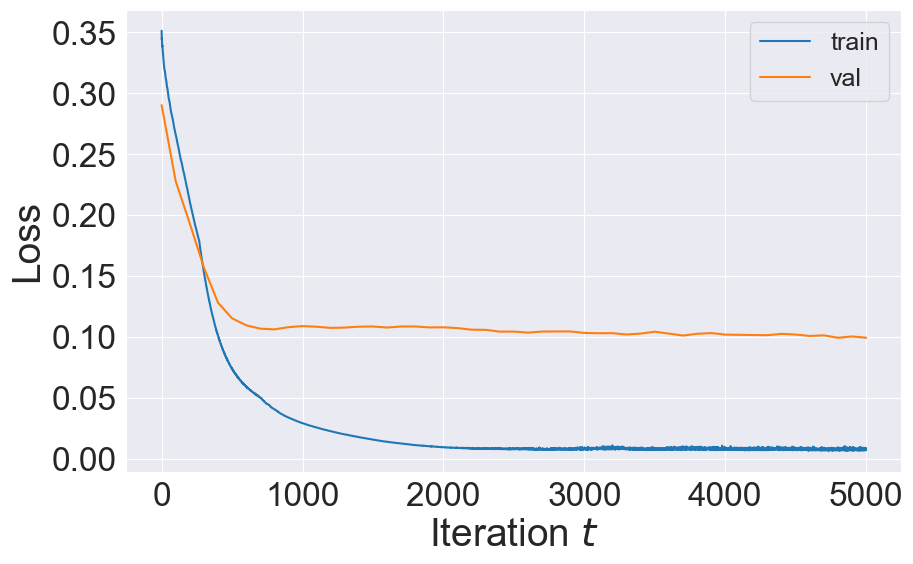

In [66]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val', 
         marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-1.png'), bbox_inches='tight')
plt.show()

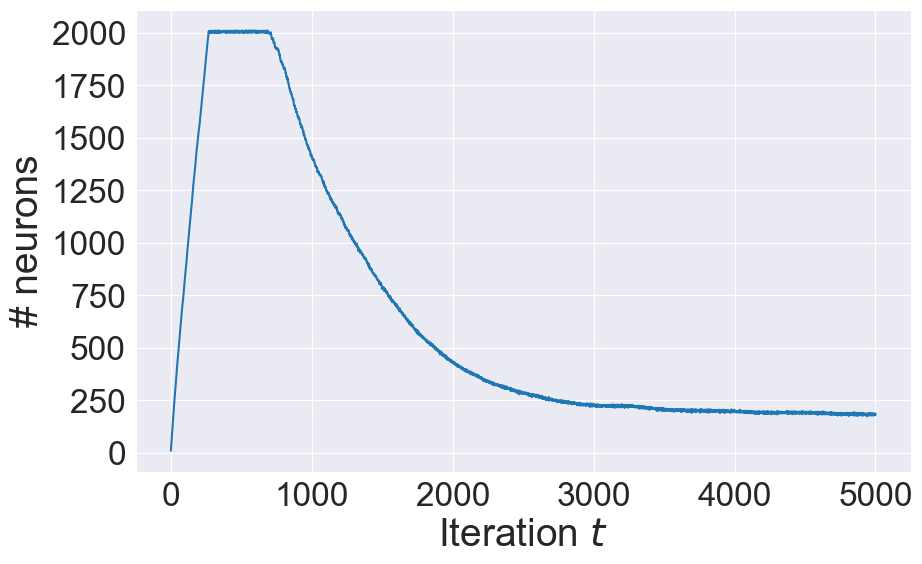

In [67]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(neurons)), neurons)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('# neurons', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'neurons-ista-10-1.png'), bbox_inches='tight')
plt.show()

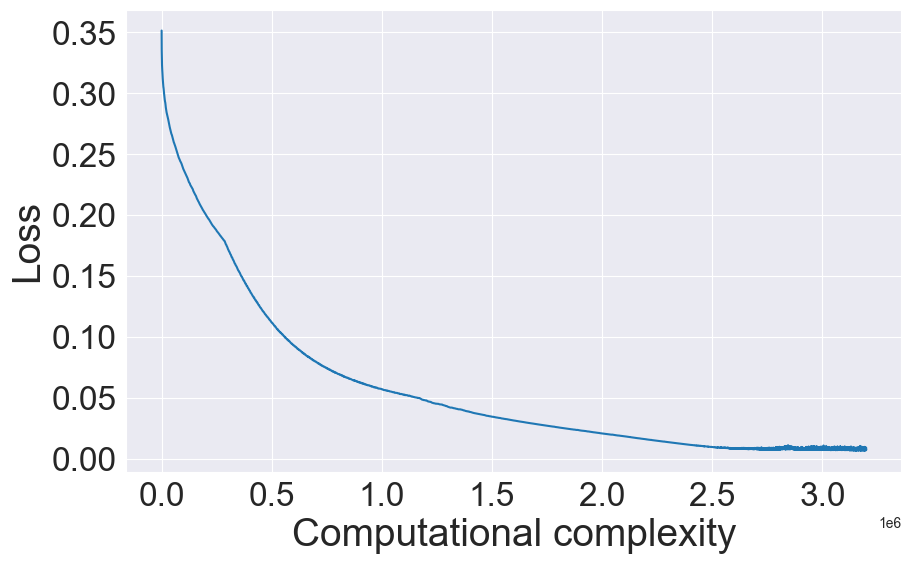

In [68]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.cumsum(neurons)[1:], train_losses)

plt.xlabel('Computational complexity', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-10-1.png'), bbox_inches='tight')
plt.show()

In [27]:
a.shape[1]

177

In [28]:
# FULL LOOP (POP-CONIC 10 sample & 10 update per step)
n_neurons = 10
n_updates = 10

a, b, _ = initialize_net(x_train, y_train, n_neurons=n_neurons)
a, b, train_losses, val_losses, neurons = train(N_STEPS//10, a, b, x_train, y_train, x_val, y_val, 
                                                n_samples=n_neurons, n_updates=n_updates)

  2%|▊                                          | 9/500 [00:00<00:07, 67.58it/s]

Train loss at step 0 : 0.33379
Validation loss at step 0 : 0.28456


 20%|████████▎                                | 102/500 [00:06<00:28, 13.97it/s]

Train loss at step 100 : 0.03760
Validation loss at step 100 : 0.11632


 42%|█████████████████▏                       | 210/500 [00:10<00:06, 46.31it/s]

Train loss at step 200 : 0.01958
Validation loss at step 200 : 0.11211


 61%|████████████████████████▊                | 303/500 [00:12<00:05, 37.85it/s]

Train loss at step 300 : 0.01701
Validation loss at step 300 : 0.10640


 81%|█████████████████████████████████▎       | 407/500 [00:14<00:01, 59.51it/s]

Train loss at step 400 : 0.01525
Validation loss at step 400 : 0.10430


100%|█████████████████████████████████████████| 500/500 [00:15<00:00, 31.49it/s]

Train loss at step 499 : 0.01344
Validation loss at step 499 : 0.11034


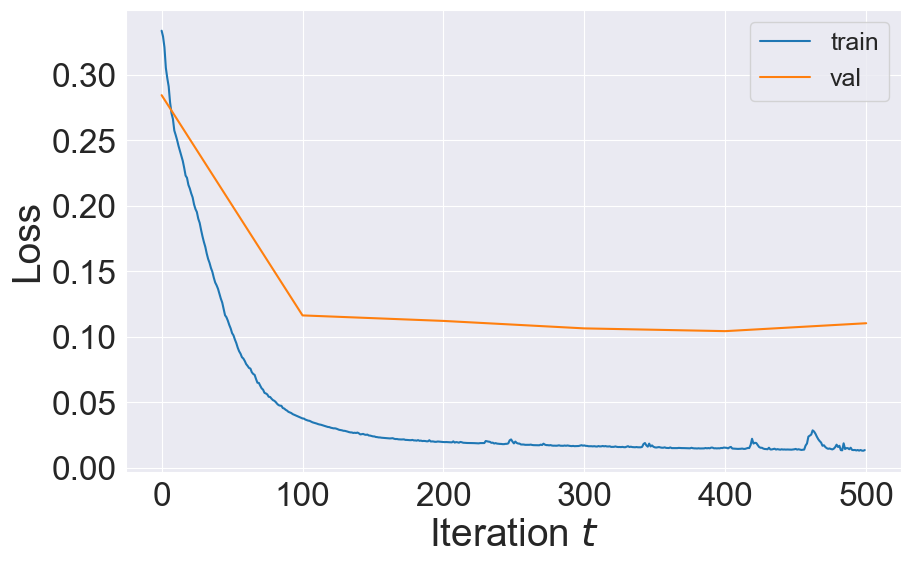

In [29]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses)) for k in range(len(val_losses))], val_losses, label='val', 
         marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'losses-ista-10-10.png'), bbox_inches='tight')
plt.show()

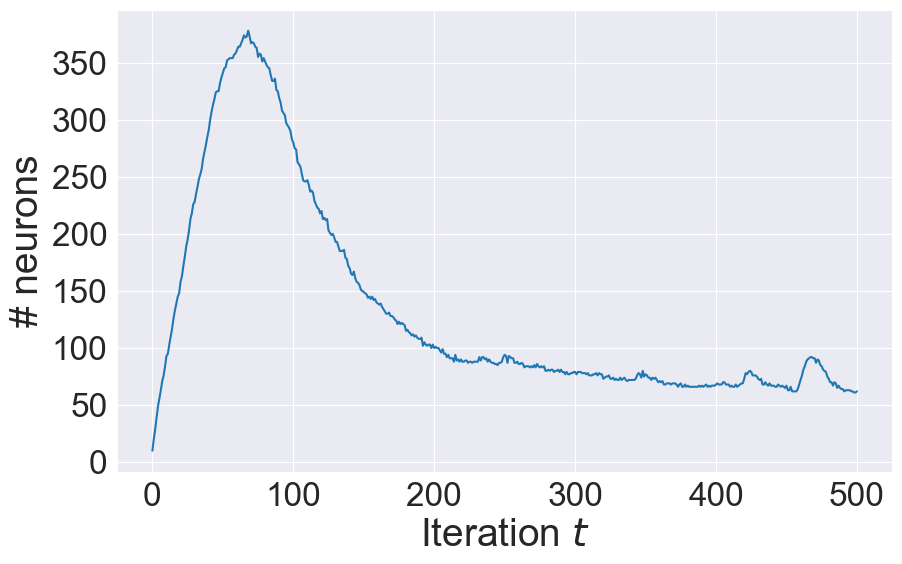

In [30]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(neurons)), neurons)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('# neurons', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'neurons-ista-10-10.png'), bbox_inches='tight')
plt.show()

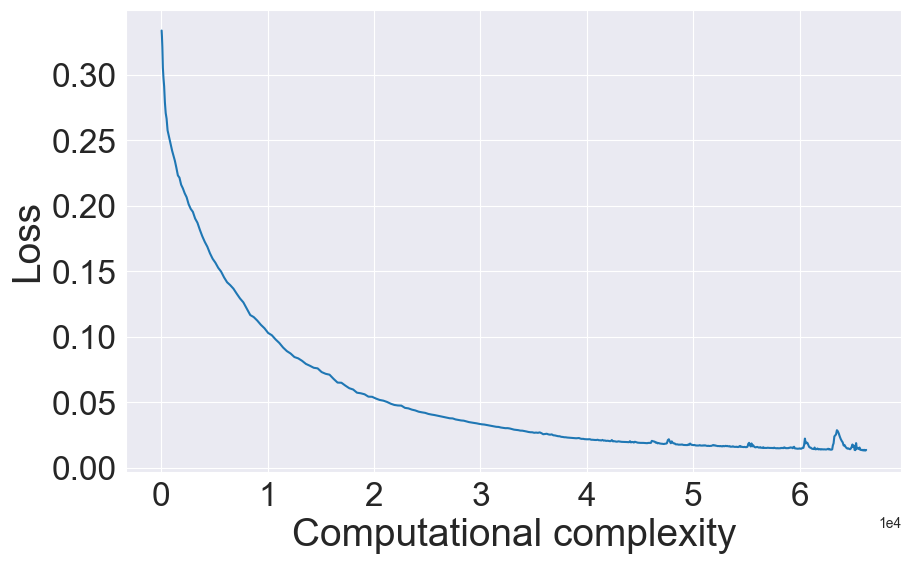

In [31]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.cumsum(neurons)[1:], train_losses)

plt.xlabel('Computational complexity', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(FIGURES_DIR, 'complexity-ista-10-10.png'), bbox_inches='tight')
plt.show()

In [32]:
a.shape

(1, 50)

## 2. Standard training with PyTorch (standard init)

In [60]:
# train data in PyTorch
x_train_pt = torch.from_numpy(x_train).float()
y_train_pt = torch.from_numpy(y_train).float()

# val data in PyTorch
x_val_pt = torch.from_numpy(x_val).float()
y_val_pt = torch.from_numpy(y_val).float()

In [61]:
# MF net with Gaussian init
m = 1024
bias = False
net = torch.nn.Sequential(*[torch.nn.Linear(in_features=INPUT_DIM, out_features=m, bias=bias),
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=m, out_features=1, bias=bias)])

# init
with torch.no_grad():
    net[0].weight.data.copy_(torch.randn(size=(m, INPUT_DIM)))
    net[2].weight.data.copy_(torch.randn(size=(1, m)))
    
opt = torch.optim.SGD(params=net.parameters(), lr=m * BASE_LR, weight_decay=LAMBDA / m)

In [62]:
do_val = True
train_losses_pt = []
val_losses_pt = []

for i in tqdm(range(N_STEPS)):
    opt.zero_grad()
    
    y_hat = net(x_train_pt) / m
    #loss = 0.5 * torch.mean((y_train_pt - y_hat) ** 2) + LAMBDA * torch.mean(net[0].weight ** 2)
    loss = 0.5 * torch.mean((y_train_pt - y_hat) ** 2)
    loss.backward()
    opt.step()
    
    with torch.no_grad():
        train_loss = loss.detach().item()
        train_losses_pt.append(train_loss)

    # validation loop if do_val is True
    if do_val:
        if i % VAL_ITER == 0:
            with torch.no_grad():
                y_hat = net(x_val_pt) / m
                val_loss = 0.5 * torch.mean((y_val_pt - y_hat) ** 2).detach().item()
                val_losses_pt.append(val_loss)
                print('Train loss at step {:,} : {:.5f}'.format(i, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(i, val_loss))
                
# last validation round after training
if do_val:
    with torch.no_grad():
        y_hat = net(x_val_pt) / m
        val_loss = 0.5 * torch.mean((y_val_pt - y_hat) ** 2).detach().item()
        val_losses_pt.append(val_loss)
        print('Train loss at step {:,} : {:.5f}'.format(i, train_loss))
        print('Validation loss at step {:,} : {:.5f}'.format(i, val_loss))

train_losses_pt = np.array(train_losses_pt)
val_losses_pt = np.array(val_losses_pt)

  0%|▏                                       | 16/5000 [00:00<00:31, 155.94it/s]

Train loss at step 0 : 0.49042
Validation loss at step 0 : 0.40444


  2%|▉                                       | 114/5000 [00:01<00:56, 86.08it/s]

Train loss at step 100 : 0.17919
Validation loss at step 100 : 0.18084


  4%|█▋                                      | 217/5000 [00:02<00:55, 86.41it/s]

Train loss at step 200 : 0.11613
Validation loss at step 200 : 0.14307


  6%|██▌                                    | 322/5000 [00:03<00:33, 140.43it/s]

Train loss at step 300 : 0.08886
Validation loss at step 300 : 0.12695


  8%|███▎                                   | 421/5000 [00:04<00:32, 141.27it/s]

Train loss at step 400 : 0.07498
Validation loss at step 400 : 0.11888


 10%|███▉                                   | 512/5000 [00:04<00:33, 133.61it/s]

Train loss at step 500 : 0.06713
Validation loss at step 500 : 0.11421


 13%|████▉                                  | 629/5000 [00:05<00:34, 128.00it/s]

Train loss at step 600 : 0.06230
Validation loss at step 600 : 0.11123


 14%|█████▌                                 | 712/5000 [00:06<00:32, 130.38it/s]

Train loss at step 700 : 0.05918
Validation loss at step 700 : 0.10912


 16%|██████▎                                | 814/5000 [00:07<00:34, 121.46it/s]

Train loss at step 800 : 0.05711
Validation loss at step 800 : 0.10751


 18%|███████▏                               | 924/5000 [00:08<00:30, 134.18it/s]

Train loss at step 900 : 0.05573
Validation loss at step 900 : 0.10622


 20%|███████▋                              | 1019/5000 [00:08<00:27, 146.90it/s]

Train loss at step 1,000 : 0.05484
Validation loss at step 1,000 : 0.10511


 22%|████████▌                             | 1120/5000 [00:09<00:25, 153.41it/s]

Train loss at step 1,100 : 0.05423
Validation loss at step 1,100 : 0.10412


 24%|█████████▎                            | 1222/5000 [00:10<00:26, 142.37it/s]

Train loss at step 1,200 : 0.05388
Validation loss at step 1,200 : 0.10333


 27%|██████████                            | 1326/5000 [00:11<00:34, 106.90it/s]

Train loss at step 1,300 : 0.05376
Validation loss at step 1,300 : 0.10270


 28%|██████████▊                           | 1424/5000 [00:11<00:25, 141.19it/s]

Train loss at step 1,400 : 0.05376
Validation loss at step 1,400 : 0.10222


 30%|███████████▌                          | 1520/5000 [00:12<00:22, 152.14it/s]

Train loss at step 1,500 : 0.05384
Validation loss at step 1,500 : 0.10179


 33%|████████████▍                         | 1632/5000 [00:13<00:21, 156.06it/s]

Train loss at step 1,600 : 0.05400
Validation loss at step 1,600 : 0.10143


 34%|█████████████                         | 1720/5000 [00:13<00:19, 164.11it/s]

Train loss at step 1,700 : 0.05420
Validation loss at step 1,700 : 0.10116


 37%|█████████████▉                        | 1827/5000 [00:14<00:18, 168.59it/s]

Train loss at step 1,800 : 0.05441
Validation loss at step 1,800 : 0.10089


 38%|██████████████▌                       | 1924/5000 [00:15<00:19, 159.47it/s]

Train loss at step 1,900 : 0.05462
Validation loss at step 1,900 : 0.10063


 41%|███████████████▍                      | 2031/5000 [00:15<00:18, 157.87it/s]

Train loss at step 2,000 : 0.05483
Validation loss at step 2,000 : 0.10039


 42%|████████████████                      | 2121/5000 [00:16<00:20, 138.65it/s]

Train loss at step 2,100 : 0.05504
Validation loss at step 2,100 : 0.10014


 45%|████████████████▉                     | 2235/5000 [00:17<00:15, 173.60it/s]

Train loss at step 2,200 : 0.05523
Validation loss at step 2,200 : 0.09988


 47%|█████████████████▋                    | 2332/5000 [00:17<00:15, 170.96it/s]

Train loss at step 2,300 : 0.05541
Validation loss at step 2,300 : 0.09966


 48%|██████████████████▍                   | 2425/5000 [00:18<00:14, 172.01it/s]

Train loss at step 2,400 : 0.05559
Validation loss at step 2,400 : 0.09946


 50%|███████████████████▏                  | 2519/5000 [00:18<00:14, 173.75it/s]

Train loss at step 2,500 : 0.05575
Validation loss at step 2,500 : 0.09931


 53%|████████████████████                  | 2632/5000 [00:19<00:12, 184.54it/s]

Train loss at step 2,600 : 0.05589
Validation loss at step 2,600 : 0.09921


 55%|████████████████████▋                 | 2726/5000 [00:19<00:13, 167.10it/s]

Train loss at step 2,700 : 0.05601
Validation loss at step 2,700 : 0.09911


 56%|█████████████████████▍                | 2822/5000 [00:20<00:12, 178.97it/s]

Train loss at step 2,800 : 0.05612
Validation loss at step 2,800 : 0.09901


 58%|██████████████████████                | 2911/5000 [00:21<00:19, 106.75it/s]

Train loss at step 2,900 : 0.05621
Validation loss at step 2,900 : 0.09892


 61%|███████████████████████               | 3030/5000 [00:21<00:13, 146.80it/s]

Train loss at step 3,000 : 0.05628
Validation loss at step 3,000 : 0.09884


 63%|███████████████████████▊              | 3126/5000 [00:22<00:13, 134.75it/s]

Train loss at step 3,100 : 0.05633
Validation loss at step 3,100 : 0.09875


 64%|████████████████████████▍             | 3223/5000 [00:23<00:11, 160.00it/s]

Train loss at step 3,200 : 0.05636
Validation loss at step 3,200 : 0.09866


 67%|█████████████████████████▎            | 3334/5000 [00:23<00:09, 170.49it/s]

Train loss at step 3,300 : 0.05638
Validation loss at step 3,300 : 0.09857


 68%|██████████████████████████            | 3425/5000 [00:24<00:10, 157.03it/s]

Train loss at step 3,400 : 0.05638
Validation loss at step 3,400 : 0.09848


 71%|██████████████████████████▊           | 3526/5000 [00:25<00:09, 159.45it/s]

Train loss at step 3,500 : 0.05638
Validation loss at step 3,500 : 0.09839


 73%|███████████████████████████▌          | 3627/5000 [00:25<00:09, 150.45it/s]

Train loss at step 3,600 : 0.05638
Validation loss at step 3,600 : 0.09830


 74%|████████████████████████████▏         | 3714/5000 [00:26<00:08, 150.79it/s]

Train loss at step 3,700 : 0.05636
Validation loss at step 3,700 : 0.09822


 77%|█████████████████████████████         | 3827/5000 [00:27<00:07, 157.71it/s]

Train loss at step 3,800 : 0.05634
Validation loss at step 3,800 : 0.09816


 79%|█████████████████████████████▊        | 3929/5000 [00:27<00:06, 157.84it/s]

Train loss at step 3,900 : 0.05631
Validation loss at step 3,900 : 0.09812


 80%|██████████████████████████████▌       | 4017/5000 [00:28<00:06, 156.83it/s]

Train loss at step 4,000 : 0.05628
Validation loss at step 4,000 : 0.09808


 82%|███████████████████████████████▎      | 4117/5000 [00:29<00:05, 148.12it/s]

Train loss at step 4,100 : 0.05625
Validation loss at step 4,100 : 0.09804


 84%|████████████████████████████████      | 4218/5000 [00:29<00:05, 142.45it/s]

Train loss at step 4,200 : 0.05622
Validation loss at step 4,200 : 0.09801


 86%|████████████████████████████████▊     | 4312/5000 [00:30<00:04, 157.44it/s]

Train loss at step 4,300 : 0.05619
Validation loss at step 4,300 : 0.09799


 88%|█████████████████████████████████▋    | 4425/5000 [00:31<00:03, 152.74it/s]

Train loss at step 4,400 : 0.05616
Validation loss at step 4,400 : 0.09798


 90%|██████████████████████████████████▎   | 4513/5000 [00:31<00:03, 161.30it/s]

Train loss at step 4,500 : 0.05613
Validation loss at step 4,500 : 0.09796


 92%|███████████████████████████████████▏  | 4622/5000 [00:32<00:02, 157.60it/s]

Train loss at step 4,600 : 0.05610
Validation loss at step 4,600 : 0.09794


 94%|███████████████████████████████████▉  | 4723/5000 [00:33<00:02, 122.88it/s]

Train loss at step 4,700 : 0.05606
Validation loss at step 4,700 : 0.09793


 97%|████████████████████████████████████▋ | 4829/5000 [00:33<00:01, 161.51it/s]

Train loss at step 4,800 : 0.05602
Validation loss at step 4,800 : 0.09792


 98%|█████████████████████████████████████▍| 4923/5000 [00:34<00:00, 155.42it/s]

Train loss at step 4,900 : 0.05598
Validation loss at step 4,900 : 0.09792


100%|██████████████████████████████████████| 5000/5000 [00:34<00:00, 143.07it/s]

Train loss at step 4,999 : 0.05594
Validation loss at step 4,999 : 0.09791


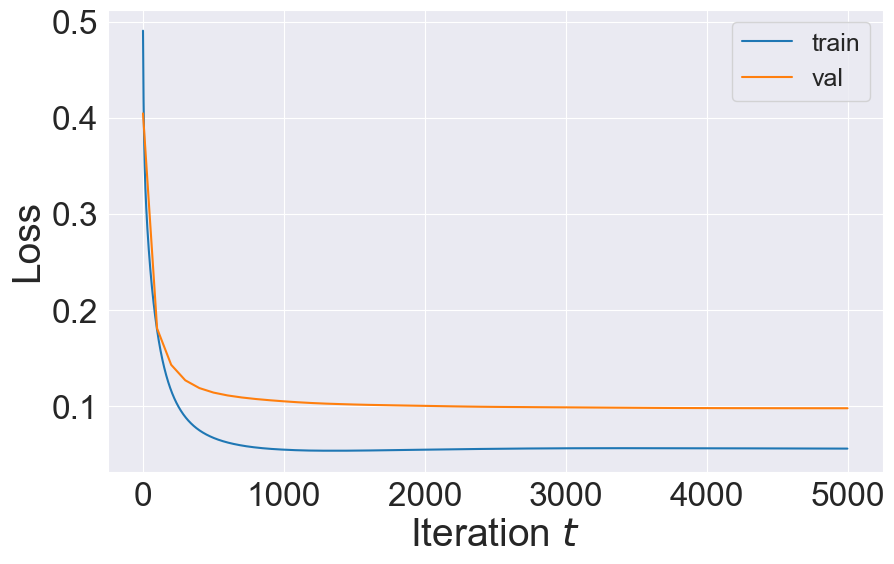

In [63]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
#plt.yscale('log')

plt.plot(np.arange(len(train_losses_pt)), train_losses_pt, label='train')
plt.plot([min(VAL_ITER * k, len(train_losses_pt)) for k in range(len(val_losses_pt))], val_losses_pt, label='val', 
         marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'losses-pt-wd.png'), bbox_inches='tight')
plt.show()

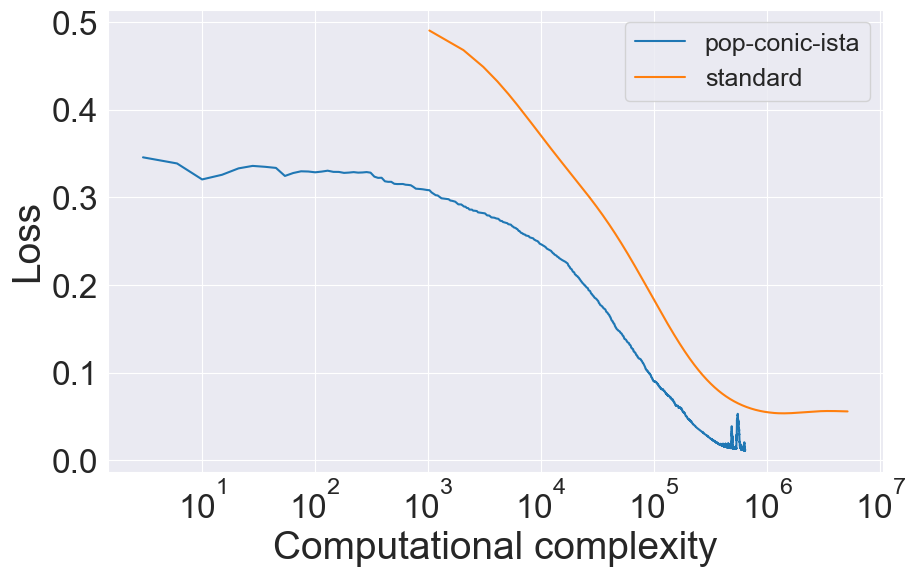

In [64]:
plt.figure(figsize=(10, 6))
marker = None #'o'
plt.xscale('log')
#plt.yscale('log')

plt.plot(np.cumsum(neurons)[1:], train_losses, label='pop-conic-ista')
plt.plot([m*(k+1) for k in range(len(train_losses_pt))], train_losses_pt, label='standard')

plt.xlabel('Computational complexity', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'complexity-pt-vs-1-1.png'), bbox_inches='tight')
plt.show()

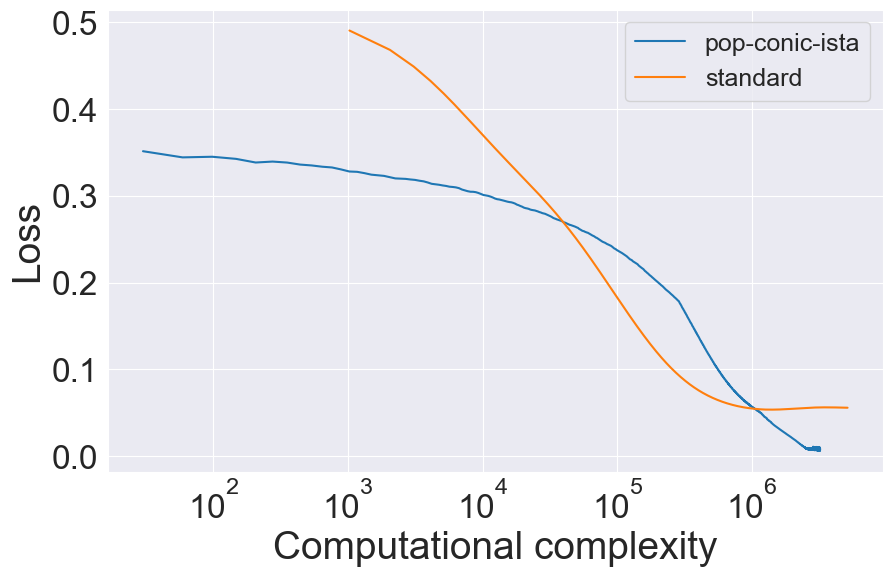

In [69]:
plt.figure(figsize=(10, 6))
marker = None #'o'
plt.xscale('log')
#plt.yscale('log')

plt.plot(np.cumsum(neurons)[1:], train_losses, label='pop-conic-ista')
plt.plot([m*(k+1) for k in range(len(train_losses_pt))], train_losses_pt, label='standard')

plt.xlabel('Computational complexity', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'complexity-pt-vs-10-1.png'), bbox_inches='tight')
plt.show()

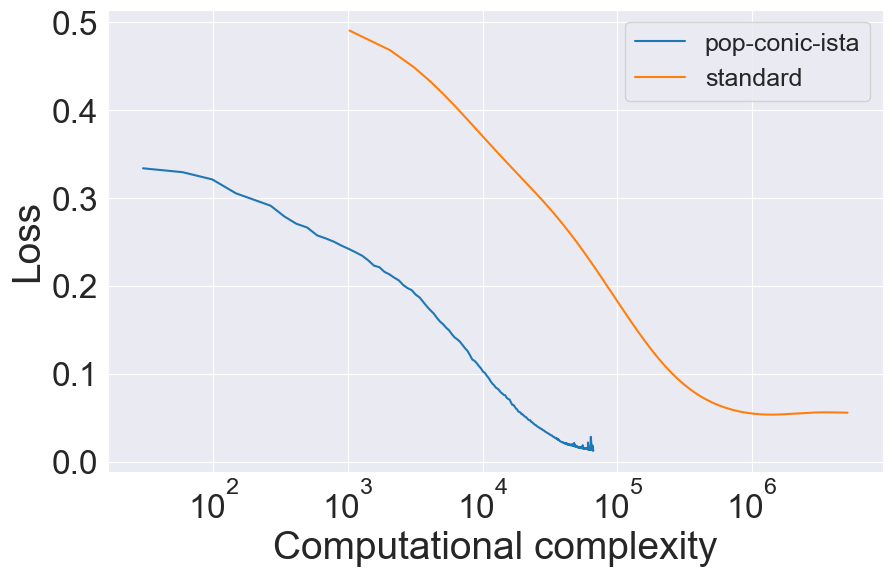

In [37]:
plt.figure(figsize=(10, 6))
marker = None #'o'
plt.xscale('log')
#plt.yscale('log')

plt.plot(np.cumsum(neurons)[1:], train_losses, label='pop-conic-ista')
plt.plot([m*(k+1) for k in range(len(train_losses_pt))], train_losses_pt, label='standard')

plt.xlabel('Computational complexity', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'complexity-pt-vs-10-10.png'), bbox_inches='tight')
plt.show()